## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
# torch.set_default_dtype(torch.float64) 


In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [3]:
importlib.reload(data)
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = n_structures)

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


## Generate NN Data

In [4]:
sigma = 0.1
dx = 0.05

full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms/normalization_eiglength_t
normalization_quartic = 1/n_atoms/normalization_eiglength_t


In [5]:
class DynamicSpliner:

    def __init__(
        self,
        start,
        stop,
        values_fn,
        derivatives_fn,
        requested_accuracy,
        device
    ) -> None:

        self.start = start
        self.stop = stop
        self.values_fn = values_fn
        self.derivatives_fn = derivatives_fn
        self.requested_accuracy = requested_accuracy

        # initialize spline with 11 points
        positions = torch.linspace(start, stop, 11)
        self.spline_positions = positions
        self.spline_values = values_fn(positions)
        self.spline_derivatives = derivatives_fn(positions)

        self.number_of_custom_dimensions = len(self.spline_values.shape) - 1

        while True:
            n_intermediate_positions = len(self.spline_positions) - 1

            if n_intermediate_positions >= 500000:
                plt.plot(self.spline_positions, self.spline_values, label = f"{len(self.spline_positions)}")
                plt.legend()
    
                raise ValueError(
                    "Maximum number of spline points reached. \
                    There might be a problem with the functions to be splined"
                )

            half_step = (self.spline_positions[1] - self.spline_positions[0]) / 2
            intermediate_positions = torch.linspace(
                self.start + half_step, self.stop - half_step, n_intermediate_positions
            )

            estimated_values = self.compute(intermediate_positions)
            new_values = self.values_fn(intermediate_positions)

            mean_absolute_error = torch.mean(torch.abs(estimated_values - new_values))
#             print (intermediate_positions[torch.max(estimated_values - new_values, 0)[1]])
#             print (estimated_values[torch.max(estimated_values - new_values, 0)[1]])
#             print (new_values[torch.max(estimated_values - new_values, 0)[1]])
            mean_relative_error = torch.mean(
                torch.abs((estimated_values - new_values) / new_values)
            )

            if (
                mean_absolute_error < self.requested_accuracy
                or mean_relative_error < self.requested_accuracy
            ):
                break

            new_derivatives = self.derivatives_fn(intermediate_positions)

            concatenated_positions = torch.cat(
                [self.spline_positions, intermediate_positions], dim=0
            )
            concatenated_values = torch.cat(
                [self.spline_values, new_values], dim=0
            )
            concatenated_derivatives = torch.cat(
                [self.spline_derivatives, new_derivatives], dim=0
            )

            sort_indices = torch.argsort(concatenated_positions, dim=0)

            self.spline_positions = concatenated_positions[sort_indices]
            self.spline_values = concatenated_values[sort_indices]
            self.spline_derivatives = concatenated_derivatives[sort_indices]
            
#             print (mean_absolute_error)
            
        self.spline_positions = self.spline_positions.to(device)
        self.spline_values = self.spline_values.to(device)
        self.spline_derivatives = self.spline_derivatives.to(device)

    def compute(self, positions):
        x = positions - self.start
        delta_x = self.spline_positions[1] - self.spline_positions[0]
        n = (torch.floor(x / delta_x)).to(dtype=torch.long)
#         print (n)

        t = (x - n * delta_x) / delta_x
        t_2 = t**2
        t_3 = t**3

        h00 = 2.0 * t_3 - 3.0 * t_2 + 1.0
        h10 = t_3 - 2.0 * t_2 + t
        h01 = -2.0 * t_3 + 3.0 * t_2
        h11 = t_3 - t_2

        p_k = self.spline_values[n]
        p_k_1 = self.spline_values[n + 1]

        m_k = self.spline_derivatives[n]
        m_k_1 = self.spline_derivatives[n + 1]

        new_shape = (-1,) + (1,) * self.number_of_custom_dimensions
        h00 = h00.reshape(new_shape)
        h10 = h10.reshape(new_shape)
        h01 = h01.reshape(new_shape)
        h11 = h11.reshape(new_shape)

        interpolated_values = (
            h00 * p_k + h10 * delta_x * m_k + h01 * p_k_1 + h11 * delta_x * m_k_1
        )

        return interpolated_values

In [3]:
# Fermi level
import ase

T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature
efermi = torch.zeros(n_structures)
for i in range(n_structures):
    efermi[i] = torch.tensor(utils.getmu(ldos[i], beta_0, xdos, n=4))
cutoff = torch.max(efermi) + 3
cutoff_index = torch.searchsorted(xdos, cutoff)



In [4]:
torch.max(efermi)

tensor(-4.3758)

In [543]:
#we want to spline up to emin -3,  rbound (maybe efermi) + 3,  
#trying full spectrum for now
sigma = 0.1
def value_fn(x):
    l_dos_E = torch.sum(torch.exp(-0.5*((x - full_eigen_energies[0].view(-1,1))/sigma)**2), dim = 0) * 2 * normalization[0]
    return l_dos_E
def derivative_fn(x):
    dfn_E = torch.sum(torch.exp(-0.5*((x - full_eigen_energies[0].view(-1,1))/sigma)**2) *
                      (-1 * ((x - full_eigen_energies[0].view(-1,1))/sigma)**2), dim =0) * 2 * normalization[0]
    return dfn_E
Dynamic_Spliner_0 = DynamicSpliner(xdos[0], xdos[-1], value_fn, derivative_fn, 1e-4, "cpu") 

In [544]:
Dynamic_Spliner_0.spline_positions.shape

torch.Size([1281])

In [545]:
from scipy.interpolate import CubicHermiteSpline
shift = -0.005
x_axis = torch.linspace(emin, emax, 800)
spliner = CubicHermiteSpline(x_axis, value_fn(x_axis), derivative_fn(x_axis))

In [547]:
def manual_call(spline_coefs, spline_positions, x):
    index = torch.searchsorted(spline_positions, x) -1
    value = 0
    x_0 = x - spline_positions[index]
    print (x_0)
    print (index)
    for j in range(0,4,1):
        value += spline_coefs[j][index]*((x_0)**(3-j))
    return value

manual_call(spliner.c, x_axis, x_axis[300]+0.020)

tensor(0.0200)
tensor(300)


tensor(0.0585)

In [208]:
value = 0
for k, c in enumerate(spliner.c):
    value += c[300] * (0.02)**(3-k)

In [209]:
value

0.16899945690771406

In [211]:
spliner(x_axis[300] + 0.02)

array(0.16899946)

array(4.17876748e-100)

<IPython.core.display.Javascript object>


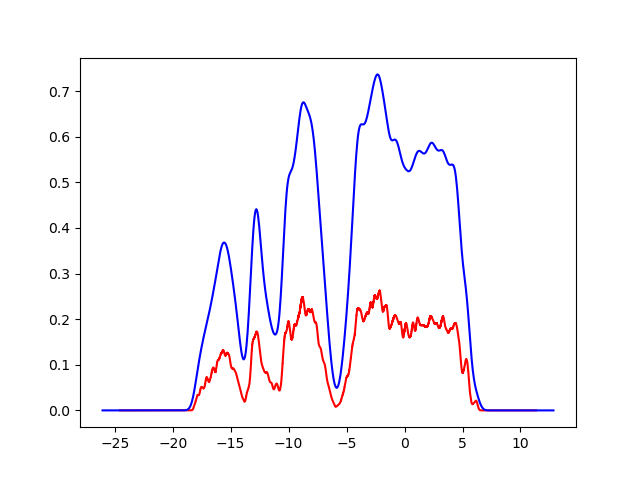

In [548]:
from scipy.interpolate import CubicHermiteSpline
shift = -0.005
x_axis2 = torch.linspace(emin, emax, 159999)
x_axis = torch.linspace(emin,emax, 8000)
spliner = CubicHermiteSpline(x_axis, value_fn(x_axis), derivative_fn(x_axis))
%matplotlib notebook
plt.plot(x_axis2,spliner(x_axis2), c= 'r')
plt.plot(xdos, ldos[0], c= 'b')

In [ ]:
#for everyone, i need to save the spline points and xaxis?, standardize on a grid of emin-1.5 and max(efermi)+3
#while evaluating everyone on emin to efermi+2, can maintain vectorization by keeping it 3D, n_samples x 4 x n_points
#maintain 0.05eV spacing?

In [221]:
max(efermi)

tensor(-4.3758)

In [248]:
(upper_bound - lower_bound)/0.001

tensor(24677.8842)

In [256]:
xaxis = torch.arange(lower_bound,upper_bound,0.001)

In [40]:
import psutil

# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM Used (GB): 99.849129984


In [65]:
emin.item()

-24.553719539983

In [273]:
lower_bound

-26.053719539983

In [509]:
emax

11.346414696331

In [272]:
upper_bound

tensor(-1.3758, dtype=torch.float64)

In [281]:
(upper_bound - lower_bound)/0.001

tensor(24678.)

## Generate Splines

In [90]:
from scipy.interpolate import CubicHermiteSpline

lower_bound = torch.round(torch.tensor(emin-3).float(), decimals = 3)
upper_bound = torch.round((torch.tensor(emax+3)).float(), decimals = 3)
n_points = ((upper_bound - lower_bound)/0.001).long()
xaxis = torch.linspace(lower_bound,upper_bound,n_points).float()
total_coefs = []
sigma = 0.1
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms/normalization_eiglength_t
for i in range(2):
    def value_fn(x):
        l_dos_E = torch.sum(torch.exp(-0.5*((x - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0) * 2 * normalization[i]
        return l_dos_E
    def derivative_fn(x):
        dfn_E = torch.sum(torch.exp(-0.5*((x - full_eigen_energies[i].view(-1,1))/sigma)**2) *
                          (-1 * ((x - full_eigen_energies[i].view(-1,1))/sigma)**2), dim =0) * 2 * normalization[i]
        return dfn_E

    spliner = CubicHermiteSpline(xaxis, value_fn(xaxis).float(), derivative_fn(xaxis).float())
    total_coefs.append(torch.tensor(spliner.c).float())
    
    

In [91]:
ldos_0 = value_fn(xdos)

In [92]:
n_points

tensor(41900)

In [93]:
torch.round((xaxis[1] - xaxis[0]), decimals = 3)

tensor(0.0010)

In [94]:
torch.tensor(spliner.c)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [95]:
a = torch.stack(total_coefs)


In [96]:
a.dtype

torch.float32

In [97]:
a.permute(0,2,1).shape

torch.Size([2, 41899, 4])

In [98]:
a.shape

torch.Size([2, 4, 41899])

In [99]:
a[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [100]:
x1 = torch.arange(3)
x2 = x1 * x1
x3 = x2 * x1
x0 = torch.ones_like(x1)

xpowers = torch.stack([x3,x2,x1,x0])



In [101]:
emax

11.346414696331

In [102]:
def manual_call(spline_coefs, spline_positions, x):
    """
    spline_coefs: shape of (n x 4 x spline_positions)
    
    return value: shape of (n x x)
    """
    interval = torch.round(spline_positions[1] - spline_positions[0], decimals = 4)
    indexes = torch.floor((x - spline_positions[0])/interval).long()
    x_1 = x - spline_positions[indexes]
    x_2 = x_1 * x_1
    x_3 = x_2 * x_1
    x_0 = torch.ones_like(x_1)
    x_powers = torch.stack([x_3, x_2, x_1, x_0])
    value = torch.sum(torch.mul(x_powers, torch.index_select(spline_coefs, 2, indexes)), axis = 1) 
    
    
    return value

# manual_call(spliner.c, x_axis, x_axis[300]+0.020)

In [103]:
l1 = manual_call(a, xaxis, xdos[:450])

In [104]:
def manual_call2(spline_coefs, spline_positions, x):
    """
    spline_coefs: shape of (n x 4 x spline_positions)
    
    return value: shape of (n x x)
    """
    interval = torch.round(spline_positions[1] - spline_positions[0], decimals = 4)
    indexes = torch.floor((x - spline_positions[0])/interval).long()
    expanded_index = indexes.unsqueeze(dim=1).expand(-1,4,-1)
    x_1 = x - spline_positions[indexes]
    x_2 = x_1 * x_1
    x_3 = x_2 * x_1
    x_0 = torch.ones_like(x_1)
    x_powers = torch.stack([x_3, x_2, x_1, x_0]).permute(1,0,2)
    value = torch.sum(torch.mul(x_powers, torch.gather(spline_coefs, 2, expanded_index)), axis = 1) 
    
    
    return value

In [105]:
a.shape

torch.Size([2, 4, 41899])

In [106]:
(xdos[:450] + torch.tensor([0,1]).view(-1,1)).shape

torch.Size([2, 450])

In [113]:
l_0 = manual_call2(a, xaxis, torch.stack([xdos[:450], xdos[:450] + 0.01]))
# l1 = manual_call(a[1], xaxis, xdos)

<IPython.core.display.Javascript object>


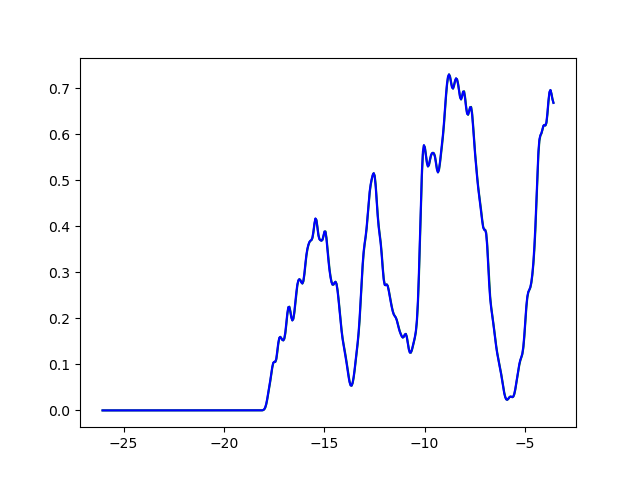

In [114]:
%matplotlib notebook
# plt.plot(xdos[:450], l1[1])
plt.plot(xdos[:450], ldos_0[:450], c= 'g')
plt.plot(xdos[:450], l_0[1], c= 'b')

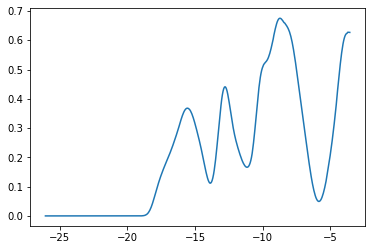

In [485]:
plt.plot(xdos[:450], l_0[0])

In [327]:
def manual_call2(spline_coefs, spline_positions, x):
    index = torch.searchsorted(spline_positions, x, side = 'right') -1
    value = 0
    x_0 = x - spline_positions[index]
    for j in range(0,4,1):
        value += spline_coefs[j][index]*((x_0)**(3-j))
    return value

l_1 = []
for i in (xdos[:493]):
    l_i = manual_call2(spliner.c, xaxis, i)
    l_1.append(l_i)
l_1 = torch.tensor(l_1)

ValueError: x and y must have same first dimension, but have shapes torch.Size([400]) and torch.Size([493])

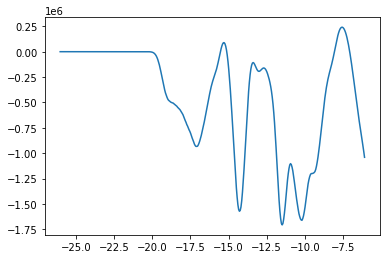

In [447]:
plt.plot(xdos[:493], l_0[1])
plt.plot(xdos[:493], l_1)
plt.plot(xdos[:493], spliner(xdos[:493]))

In [324]:
cutoff_index

tensor(493)

In [321]:
efermi[1]

tensor(-5.7455, dtype=torch.float64)

<IPython.core.display.Javascript object>


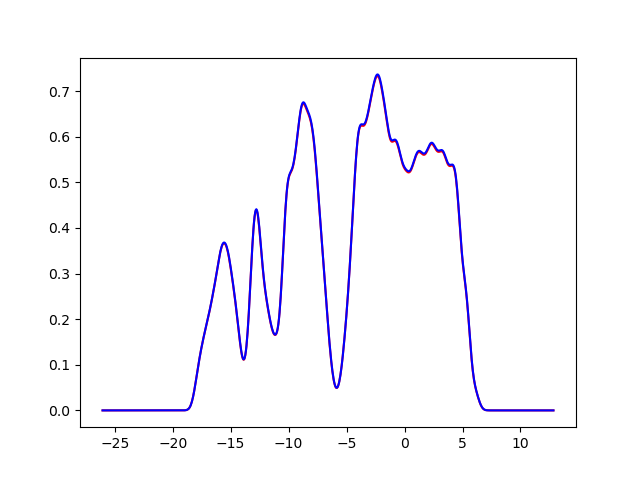

In [116]:
from scipy.interpolate import CubicHermiteSpline
shift = -0.005
spliner = CubicHermiteSpline(xdos, value_fn(xdos), derivative_fn(xdos))
%matplotlib notebook
plt.plot(xdos,spliner(xdos + 0.01), c= 'r')
plt.plot(xdos, ldos[0], c= 'b')

In [119]:
result = Dynamic_Spliner_0.compute(xdos[:740]-0.05)

<IPython.core.display.Javascript object>


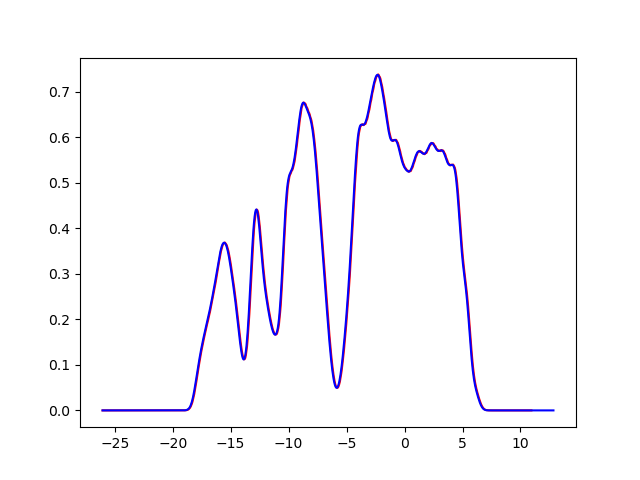

In [120]:
%matplotlib notebook
plt.plot(xdos[:740],result, c= 'r')
plt.plot(xdos, ldos[0], c= 'b')

In [51]:
l_dos_E = torch.sum(torch.exp(-0.5*((xdos - full_eigen_energies[0].view(-1,1))/sigma)**2), dim = 0) * 2 * normalization[0]
dfn_E = torch.sum(torch.exp(-0.5*((xdos - full_eigen_energies[0].view(-1,1))/sigma)**2), dim =0) * 2 * normalization[0]*(-1 * xdos/ sigma**2)


<IPython.core.display.Javascript object>


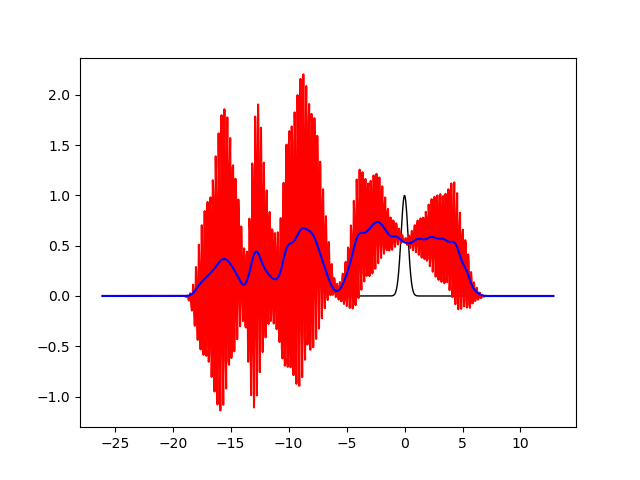

tensor(0.0523)
tensor(0.0007)
tensor(0.0003)
tensor(1.6398e-05)
tensor(1.0234e-06)
tensor(6.4576e-08)


In [85]:

def value_fn(x):
    l_dos_E = torch.exp(-0.5*(((x-0)/sigma)**2))  
    
#     print (x.shape)
    return l_dos_E
def derivative_fn(x):
    dfn_E = torch.exp(-0.5*(((x - 0)/sigma)**2))*(-1 * x/ sigma**2)    
    return dfn_E
# l_dos_E = value_fn(xdos)#torch.exp(-0.5*(((xdos-0)/sigma)**2))
# dfn_E = derivative_fn(xdos)#torch.exp(-0.5*(((xdos-0)/sigma)**2))*(-1 * xdos/ sigma**2)
plt.plot(torch.linspace(-5,5, 800), gauss, c = 'black', label = 'true', linewidth = 1)
Dynamic_Spliner_0 = DynamicSpliner(-5, 5, value_fn, derivative_fn, 1E-8, "cpu") 


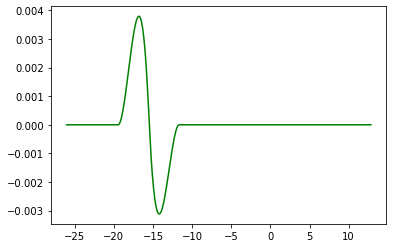

In [85]:
ldos_0 = Dynamic_Spliner_0.compute(xdos)
plt.plot(xdos, ldos_0, c= 'g')
# plt.plot(xdos, l_dos_E, c = 'b')
# plt.plot(xdos, dfn_E/100, c= 'r')

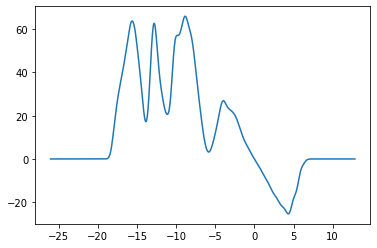

In [10]:
Dynamic_Spliner_0.spline_positions.shape


torch.Size([163841])

<IPython.core.display.Javascript object>


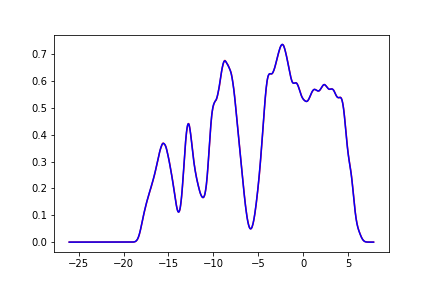

In [106]:
%matplotlib notebook
a = 0
ldos_0 = Dynamic_Spliner_0.compute(xdos[a:-100] - 0.01)
plt.plot(xdos[a:-100], ldos_0, c= 'r')
plt.plot(xdos[a:-100], ldos[0, a:-100], c= 'b')

In [5]:
#Determine right_bound as highest eigenenergy
def determine_rightbounds(eigen_energies):
    right_bounds = []
    for energies in (eigen_energies):
        right_bound = torch.max(energies)
        right_bounds.append(right_bound)
    right_bounds = torch.vstack(right_bounds)
    return right_bounds


rbounds = determine_rightbounds(full_eigen_energies)

def determine_leftbounds(eigen_energies):
    left_bounds = []
    for energies in (eigen_energies):
        left_bound = torch.min(energies)
        left_bounds.append(left_bound)
    left_bounds = torch.vstack(left_bounds)
    return left_bounds
lbounds = determine_leftbounds(full_eigen_energies)


In [6]:
# Determine Fermi level with respect to upper bound
# Get core level references

In [7]:
# Fermi level
import ase

T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature
efermi = np.zeros(n_structures)
for i in range(n_structures):
    efermi[i] = utils.getmu(ldos[i], beta_0, xdos, n=4)

In [8]:
max(efermi)

-4.375835372334838e+00

In [9]:
##Generate individual xdos, ldos
n_xdos = []
n_ldos = []

sigma = torch.tensor(0.3)
ndos = 200

emin = -24.5537
emax = 11.3464

for i in tqdm(range(n_structures)):
    x_dos = torch.linspace(lbounds[i].item() - 1.5, rbounds[i].item()- (10 * sigma),ndos)
    l_dos = torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    n_xdos.append(x_dos)
    n_ldos.append(l_dos)
    
n_xdos = torch.vstack(n_xdos)
n_ldos = torch.vstack(n_ldos)
n_ldos = ((n_ldos.T * normalization ).T)* 2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:11<00:00, 89.28it/s]


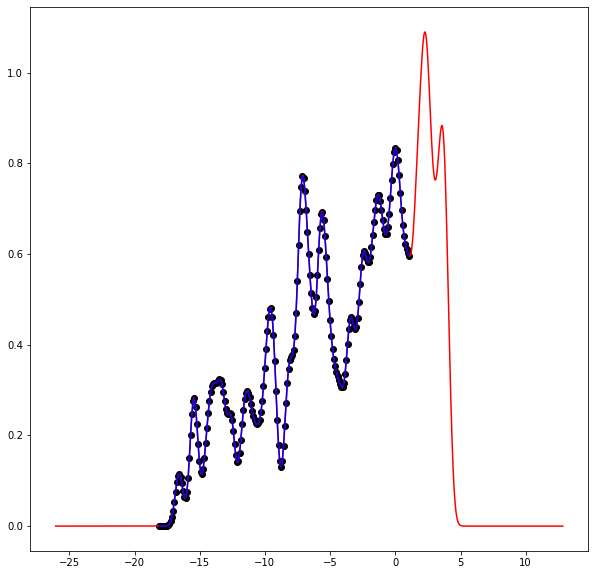

In [10]:
i = 800
plt.rcParams['figure.figsize'] = 10, 10
plt.plot(xdos, ldos[i], c = 'r')
plt.plot(n_xdos[i], n_ldos[i], c= 'b')
plt.scatter(n_xdos[i], n_ldos[i], c= 'black')

In [11]:
np.save("n_ldos.npy", n_ldos)
np.save("n_xdos.npy", n_xdos)

## Quartic dataset

In [12]:
#Determine bounds
#Determine right_bound as highest eigenenergy
rbounds = determine_rightbounds(full_eigen_energies)
efermi = torch.tensor(efermi)

In [13]:
torch.max(efermi, dim = 0)

torch.return_types.max(
values=tensor(-4.3758),
indices=tensor(723))

In [14]:
torch.min(efermi, dim = 0)

torch.return_types.min(
values=tensor(-7.8526),
indices=tensor(346))

In [15]:
torch.min(torch.min(torch.tensor([5,1])), torch.tensor(2))

tensor(1)

In [16]:
def quartic_dos(energies,xdos, sigma):
   
    left_b = energies - (np.sqrt(7) * sigma)

    output = torch.zeros_like(xdos)

    left_bound = torch.searchsorted(xdos, left_b)
    
    xdos_interval = xdos[1]-xdos[0]
    interval = int((2 * (np.sqrt(7) * sigma))/xdos_interval) + 1
    indexes = torch.clamp(left_bound.repeat(interval,1) + torch.arange(0,interval,1).view(-1,1), 0, len(xdos)-1)
                     
    E = torch.clamp((energies.view(1,-1) - xdos[indexes]), min = -1* (np.sqrt(7) * sigma), max = (np.sqrt(7) * sigma))
    values = (E**2 - (7 * (sigma**2))) **2 / ((16/15) * (np.sqrt(7) * sigma)**5)
    output.index_add_(0, indexes.flatten(), values.flatten())

#     output = -1 * output
    
    return output

In [17]:
#1
full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
sorted_full_eigen_energies = [torch.sort(i)[0] for i in full_eigen_energies]
#2
#Sticking to sigma=0.3, 2eV above the max fermi level will correspond to max energy of 2.8ev above the max fermi level
sorted_full_eigen_energies_2 = []
for e in sorted_full_eigen_energies:
    
    sorted_full_eigen_energies_2.append(e[:torch.searchsorted(e, torch.max(efermi) + 2.8)])
#3
sorted_full_eigen_energies_3 = []
for i,e in enumerate(sorted_full_eigen_energies):    
    sorted_full_eigen_energies_3.append(e[:torch.searchsorted(e, efermi[i] + 2.8)])

In [18]:
##Generate individual xdos, ldos


n_xdos2 = []
n_ldos2 = []

sigma = torch.tensor(0.3)
ndos = 778 #+ int(30/0.05)


emin = -24.5537
emax = 11.3464
for i in tqdm(range(n_structures)):
    #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
    x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
    l_dos2 = quartic_dos(sorted_full_eigen_energies[i], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    n_xdos2.append(x_dos2)
    n_ldos2.append(l_dos2)
    
n_xdos2 = torch.vstack(n_xdos2)
n_ldos2 = torch.vstack(n_ldos2)
n_ldos2 = ((n_ldos2.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:03<00:00, 343.44it/s]


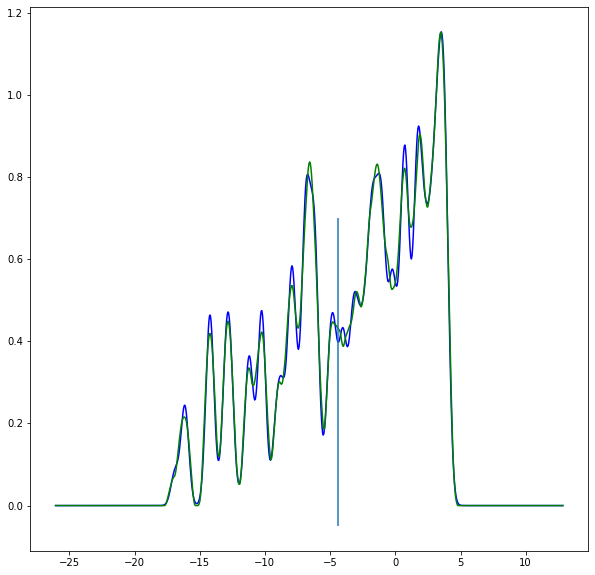

In [19]:
i = 700
#plt.plot(n_xdos[i], n_ldos[i], c= 'r')
plt.plot(xdos, ldos[i], c= 'b')
plt.plot(xdos, n_ldos2[i], c= 'g')
plt.vlines(x = efermi[i], ymin = -0.05, ymax = 0.7)

Datasets generated: <br/>
1) Full quartic dataset <br/> 
2) Up to max(Efermi + 2) <br/> 
3) Up to Efermi + 2 for everyone <br/>


In [20]:
##Generate Full quartic dataset


full_xdos = []
full_ldos = []

sigma = torch.tensor(0.3)
ndos = 778 #+ int(30/0.05)


emin = -24.5537
emax = 11.3464



full_xdos = torch.arange(emin - 1.5, emax + 1.5,0.05)
for i in tqdm(range(n_structures)):
    #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
    #x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
    full_ldos_i = quartic_dos(sorted_full_eigen_energies[i], full_xdos, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
#     n_xdos2.append(x_dos2)
    full_ldos.append(full_ldos_i)
    
#n_xdos2 = torch.vstack(n_xdos2)
full_ldos = torch.vstack(full_ldos)
full_ldos = ((full_ldos.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:02<00:00, 381.87it/s]


In [21]:
## Generate up to max(Efermi + 2)
full_xdos_2 = []
full_ldos_2 = []

sigma = torch.tensor(0.3)
ndos = 778 #+ int(30/0.05)


emin = -24.5537
emax = torch.max(efermi)



full_xdos_2 = torch.arange(emin - 1.5, emax + 1,0.05)
for i in tqdm(range(n_structures)):
    #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
    #x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
    full_ldos_i = quartic_dos(sorted_full_eigen_energies_2[i], full_xdos, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
#     n_xdos2.append(x_dos2)
    full_ldos_2.append(full_ldos_i)
    
#n_xdos2 = torch.vstack(n_xdos2)
full_ldos_2 = torch.vstack(full_ldos_2)
full_ldos_2 = ((full_ldos_2.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:01<00:00, 542.76it/s]


In [22]:
# ## Generate up to Efermi + 2 (4?)

# full_xdos_3 = []
# full_ldos_3 = []

# sigma = torch.tensor(0.3)
# ndos = 778 #+ int(30/0.05)


# emin = -24.5537
# emax = torch.max(efermi)




# for i in tqdm(range(n_structures)):
#     xdos_3 = torch.arange(emin - 1.5, efermi[i] + 1,0.05)
#     #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
#     #x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
#     full_ldos_i = quartic_dos(sorted_full_eigen_energies_3[i], full_xdos, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
#     full_xdos_3.append(xdos_3)
#     full_ldos_3.append(full_ldos_i)
    
# full_xdos_3 = torch.vstack(full_xdos_3)
# full_ldos_3 = torch.vstack(full_ldos_3)
# full_ldos_3 = ((full_ldos_3.T * normalization_quartic ).T)* 2

# #Do cutting here?

## Gradient descent in loss functions

In [23]:
from dostools.loss.loss import t_get_mse

In [24]:
#Goal is to only evaluate loss on the relevant energies
# 1) Need to know the range of relevant energies 
# 2) Should train the energy levels individually,
# 3) Need a dataset class
# 4) Model receives data and determines which one to feed to
# 5) Optimizer updates all relevant weights at once

# To define Loss
# 1) String together all the xdos, ldos values
# 2) Calculate loss on that interval

In [25]:
# Quartic polynomials
# 1) 

In [26]:
#Need to see if i should align all at once or just one at a time

In [24]:
def MSE_shift_discrete(pred: torch.tensor, target_eigvals: list, normalization:torch.tensor, xdos: torch.tensor, rbound:int, n_epochs:int, draw = False):
    #cannot rely solely on error values because pred might look different from target
    alignments = []
    all_mse = []
    sigma = 0.3
    patience = 20
    counter = 0
###DRAW
    if draw:
        fig, ax_list = plt.subplots(1,1)
    #     ax_list = ax_list.flatten()
        line, = ax_list.plot(xdos, pred[0], label = "Aligned True")
        z, = ax_list.plot(xdos, pred[0], label = "Prediction")
        ax_list.vlines(x = -2.3231, ymin = -0.05, ymax = 1, color = 'black')
        fig.legend([line,z], labels = ["Aligned True", "Prediction"], loc = "lower center")

    for i in tqdm(range(len(target_eigvals))):        
        xdos_i = xdos
        shift = torch.nn.parameter.Parameter(torch.tensor(0.))
        best_mse = torch.tensor(1)
        best_state = shift.clone()
        opt_LBFGS = torch.optim.LBFGS([shift], lr = 100, line_search_fn = 'strong_wolfe')#, weight_decay = 0)
        opt_adam = torch.optim.Adam([shift], lr = 1, weight_decay = 0)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 0.01)
        if draw:
            z.set_ydata(pred[i].detach().numpy())
        prev_mse = torch.tensor(1)
        for epoch in range(n_epochs):            
            opt_LBFGS.zero_grad()
            def closure():
                opt_LBFGS.zero_grad()
                ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
                ldos_i = ((ldos_i * normalization[i] ))* 2
                mse = t_get_mse(pred[i,:rbound], ldos_i[:rbound])
                mse.backward()
                return mse
                            
            
            if epoch == 0:
                opt_LBFGS.step(closure)
            else:
                opt_adam.step(closure)
            
            with torch.no_grad():
                ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
                ldos_i = ((ldos_i * normalization[i] ))* 2
                mse = t_get_mse(pred[i,:rbound], ldos_i[:rbound])
                scheduler.step(mse)
            if mse < best_mse:
                
                best_mse = mse.detach().clone()
                best_state = shift.detach().clone()
            
            if mse < prev_mse * (1 - 1e-3):
                counter = 0 
            else:
                counter +=1
            prev_mse = mse
#                 counter += 1
#                 if counter >= patience:
#                     shift = torch.nn.parameter.Parameter(torch.tensor(best_state))
#                     counter = 0
#             else:
                
##DRAW      
            if draw:
                ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
                ldos_i = ((ldos_i * normalization[i] ))* 2
                line.set_ydata(ldos_i.detach().numpy())
                fig.suptitle("Epochs: {}, Shift: {:.3}, Best Shift: {:.3}, Current loss:{:.3}, Best Loss: {:.3}, LR: {}".format(epoch, shift.item(), best_state.item(), mse.item(), best_mse.item(), opt_adam.param_groups[0]['lr']))
                fig.canvas.draw()
                fig.canvas.flush_events()
            
            
            if mse < 1e-10:
#                 print ("break at lr: {}, mse : {}, epoch : {}, shift: {}". format(opt.param_groups[0]['lr'], mse, epoch, shift.item()))
                break
            if best_mse.item() > 1e-5 and counter >= patience: #does not really work because i dont know when the error is unacceptable, maybe only applies to trained models?
                shift = torch.nn.parameter.Parameter(best_state)
                opt_adam = torch.optim.Adam([shift], lr = opt_adam.param_groups[0]['lr'], weight_decay = 0)
                counter = 0
                    
            if opt_adam.param_groups[0]['lr'] < 0.1 and (counter >= patience or mse.item() < 1e-10):
#                 print ("break at lr: {}, mse : {}, epoch : {}, shift: {}". format(opt.param_groups[0]['lr'], mse, epoch, shift.item()))
                break


        alignments.append(torch.tensor(best_state.item()))
        ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
        ldos_i = ((ldos_i * normalization_quartic[i] ))* 2
        mse = t_get_mse(pred[i,:rbound], ldos_i[:rbound])
        all_mse.append(mse)
                
        
    all_mse = torch.vstack(all_mse)
    alignments = torch.vstack(alignments)
    
    return all_mse, alignments


In [28]:
def MSE_shift_continuous(x_pred, target): #Should make the model repredict the DOS at a shifted energy value
    alignments = torch.nn.parameter.Parameter(torch.zeros(len(target)))
    pass

In [29]:
def MSE_shift_fourier(x_pred, target):
    alignments = torch.nn.parameter.Parameter(torch.zeros(len(target)))
    pass

In [30]:
def MSE_shift_continuous(pred, target): #shifts the prediction values, 1) want to extract the inner representation with a method. 2) modify the energy input values at the inner representation layer, 3) optimize the optimal alignment values 
    alignments = torch.nn.parameter.Parameter(torch.tensor(0.))
    pass

In [31]:
##Generate shifted quartic dataset


full_xdos = []
shifted_full_ldos = []

sigma = torch.tensor(0.3)
# ndos = 778 #+ int(30/0.05)


emin = -24.5537
emax = 11.3464

true_alignments = (torch.rand(1039)-0.5) * 4

full_xdos = torch.arange(emin - 1.5, emax + 3,0.05)
for i in tqdm(range(n_structures)):
    #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
    #x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
    shifted_full_ldos_i = quartic_dos(sorted_full_eigen_energies[i] + true_alignments[i], full_xdos, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
#     n_xdos2.append(x_dos2)
    shifted_full_ldos.append(shifted_full_ldos_i)
    
#n_xdos2 = torch.vstack(n_xdos2)
shifted_full_ldos = torch.vstack(shifted_full_ldos)
shifted_full_ldos = ((shifted_full_ldos.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:02<00:00, 360.90it/s]


In [45]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [71]:
draw = False
i = 0
j = 1039

mse3, shift3 = MSE_shift_discrete(shifted_full_ldos[i:i+j], sorted_full_eigen_energies[i:i+j], normalization_quartic[i:i+j], full_xdos, 479, 50, draw = draw)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [02:26<00:00,  7.10it/s]


tensor(-1.9190)

In [72]:
mse3

tensor([[2.5008e-14],
        [8.6894e-17],
        [4.9784e-12],
        ...,
        [1.4592e-14],
        [7.5228e-11],
        [1.0957e-15]], grad_fn=<CatBackward0>)

In [89]:
i = 688
print (shift3[i])
print (true_alignments[i])

tensor([1.3265])
tensor(1.3303)


In [60]:
true_alignments[676]

tensor(1.2854)

In [77]:
torch.where(mse3 > 1e-2)

(tensor([699]), tensor([0]))

In [88]:
torch.where(abs(true_alignments[:,None] - shift3) > 3e-3)[0]

tensor([688, 693, 719, 721, 722, 738])

In [38]:
torch.where(abs(true_alignments[:,None] - shift3) > 1e-3)[0]

tensor([361, 443, 676, 688, 691, 693, 702, 704, 707, 709, 711, 716, 719, 721,
        722, 738])

In [1738]:
shift3

tensor([[1.5576]])

In [1728]:
shift2[120]

tensor([1.3762])

In [1710]:
shift[i:i+j]

tensor([[1.0933]])

In [1737]:
true_alignments[i:i+j]

tensor([1.5576])

In [1730]:
true_alignments[120]

tensor(1.5576)

In [1318]:
normalization_quartic[685:686]

tensor([0.0303])

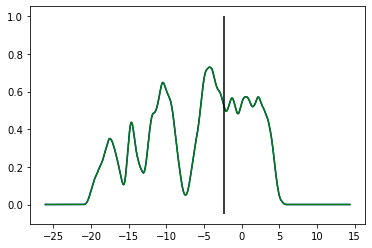

In [1549]:
%matplotlib inline
i = 26
with torch.no_grad():
    pred_opt_shift = quartic_dos(sorted_full_eigen_energies[i:i+1][0] + shift[i], full_xdos, sigma) * normalization_quartic[i:i+1][0]  * 2
    plt.plot(full_xdos, pred_opt_shift, c= 'b')
    plt.plot(full_xdos, shifted_full_ldos[i], c= 'g')
    plt.vlines(x = -2.3231, ymin = -0.05, ymax = 1, color = 'black')

In [892]:
pred_opt_shift = quartic_dos(sorted_full_eigen_energies[0] - 0.6624, full_xdos, sigma) * normalization_quartic[0] * 2

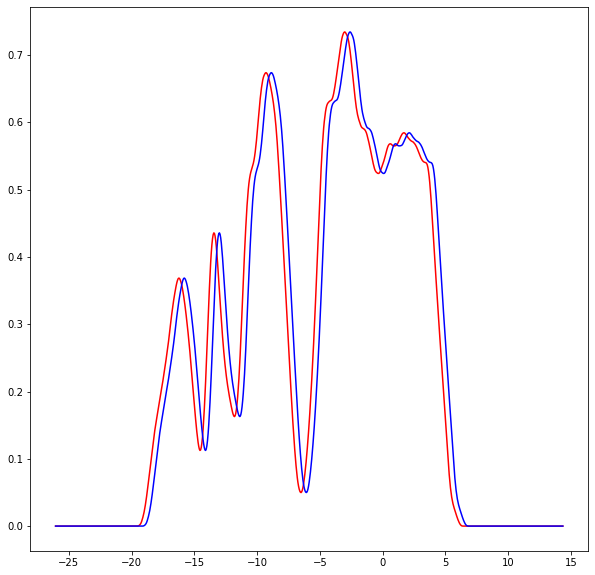

In [893]:
plt.plot(full_xdos, pred_opt_shift.detach(), c= 'r')
plt.plot(full_xdos, shifted_full_ldos[0].detach(), c = 'b')

## Quartic Peaks Debug


In [516]:
#LOL NOW RUN FOR GAUSSIAN TO COMPARE

##Generate individual xdos, ldos
n_xdos = []
n_ldos = []

sigma = torch.tensor(0.3)
ndos = 778


emin = -24.5537
emax = 11.3464

for i in tqdm(range(n_structures)):
    x_dos = torch.linspace(lbounds[i].item() - 1.5, rbounds[i].item()- (10 * sigma),ndos)
    l_dos = torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    n_xdos.append(x_dos)
    n_ldos.append(l_dos)
    
n_xdos = torch.vstack(n_xdos)
n_ldos = torch.vstack(n_ldos)
n_ldos = ((n_ldos.T * normalization ).T)* 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [01:20<00:00, 12.92it/s]


In [551]:
#Quartic polynomials
def quartic(x, xdos, sigma):
    #identify bounds
    left_b = x- 1.2*(np.sqrt(7)*(sigma))
    right_b = x + 1.2*(np.sqrt(7)*(sigma))
    #Obtain mask
    mask = torch.where((left_b < xdos) & (xdos < right_b))
    output = torch.zeros_like(xdos)
    output[mask] = ((x-xdos[mask])**2 - (7 * sigma**2)) **2 / ((16/15) * (np.sqrt(7) * sigma)**5)
    
    return output

def quartic_peak(x, xdos, sigma):
    #Identify bounds
#     left_b = x - (np.sqrt(7) * sigma)
#     right_b = x + (np.sqrt(7) * sigma)
    
    #Obtain mask
    #mask = ((xdos >= left_b.view(-1,1)) & (xdos <= right_b.view(-1,1)))
    
    
    #Initialize output
    output = torch.zeros(len(xdos))

    
#     a = ((x.view(-1,1) - torch.masked_select(xdos.expand(len(x), len(xdos)),mask))**2 - (7 * (sigma**2)))**2 / ((16/15) * (np.sqrt(7) * sigma)**5)
#     print (a.shape)
#     print (torch.masked_select(xdos.expand(len(x), len(xdos)),mask).shape)
    
#     output[mask] = ((x.view(-1,1) - torch.masked_select(xdos.expand(len(x), len(xdos)),mask))**2 - (7 * (sigma**2)))**2 / ((16/15) * (np.sqrt(7) * sigma)**5)
    for E in x:
        output += quartic(E, xdos, sigma)
    
    return output
    
    
def quartic_peak_E(energies, xdos, sigma):
    if False:#len(energies) <= len(xdos):
        output = quartic_peak(energies, xdos, sigma)
    else:
        output = torch.zeros_like(xdos)
        for i, x in enumerate(xdos):
            l_energies = torch.searchsorted(energies, x - (np.sqrt(7)*(sigma)))
            r_energies = torch.searchsorted(energies, x + (np.sqrt(7)*(sigma)))
            if r_energies != l_energies:
                output[i] = torch.sum(((energies[l_energies:r_energies].view(-1,1) - x)**2 - (7 * (sigma**2))) **2 / ((16/15) * (np.sqrt(7) * sigma)**5))
                
        return output
                    

In [503]:
xaxis = torch.arange(-50,50,0.04)
print (xaxis.shape)
energies = torch.tensor([-5, 0, 1, 2, 3, 4])
left_b = energies - (np.sqrt(7) * sigma)
right_b = energies + (np.sqrt(7)*sigma)

output = torch.zeros_like(xaxis)

left_bound = torch.searchsorted(xaxis, left_b)
indexes = left_bound.repeat(20,1) + torch.arange(0,20,1).view(-1,1)
values = torch.clamp((energies.view(1,-1) - xaxis[indexes])**2 - (7 * (sigma**2)) **2 / ((16/15) * (np.sqrt(7) * sigma)**5), max = 0)

output.index_add_(0, indexes.flatten(), values.flatten())

output = -1 * output
# xaxis = xaxis.expand(len(energies), len(xaxis))
# output = torch.zeros_like(xaxis)
# values = ((energies.reshape(6,1) - (xaxis[mask].reshape(len(energies), -1)))**2 - (7 * (sigma**2))) **2 / ((16/15) * (np.sqrt(7) * sigma)**5)

# output[mask] = values.flatten()
# output = torch.sum(output, 0)


torch.Size([2500])


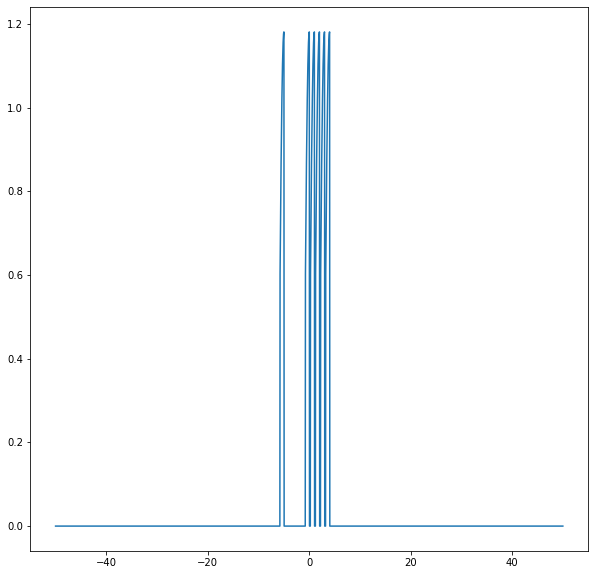

In [505]:
plt.plot(torch.arange(-50,50,0.04), output)

## Inspecting default train-test split and generating biased dataset

In [115]:
diamond_range = np.arange(0,324,1)
beta_tin_range = np.arange(324,604,1)
liquid_range = np.arange(604, 673, 1)
clusters_range = np.arange(673, 939, 1)
amorphous_range = np.arange(939, 1039, 1)
def find_structures_in_index(index):
    structures = {}
    structures['diamond'] =  np.sum(np.isin(index, diamond_range))
    structures['beta_tin'] = np.sum(np.isin(index, beta_tin_range))
    structures['liquid'] = np.sum(np.isin(index, liquid_range))
    structures['clusters'] = np.sum(np.isin(index, clusters_range))
    structures['amorphous'] = np.sum(np.isin(index, amorphous_range))
    
    return structures

train_structures = find_structures_in_index(train_index)

In [116]:
train_structures

{'diamond': 249,
 'beta_tin': 231,
 'liquid': 58,
 'clusters': 209,
 'amorphous': 84}

In [86]:
#For biased dataset, we want roughly 80 amorphous structures in the test set and 20 in the train set to test the model's extrapolatability


In [108]:
#Selected Amorphous structures

amorph_train = np.arange(939,1039,1)
np.random.seed(0)
np.random.shuffle(amorph_train)

amorph_test = amorph_train[:80]
amorph_train = amorph_train[80:]

n_structures = 939
np.random.seed(0)
n_train = int(0.8 * 1039)-20
remaining_train_index = np.arange(n_structures)
np.random.shuffle(remaining_train_index)

remaining_test_index = remaining_train_index[n_train:]
remaining_train_index = remaining_train_index[:n_train]

biased_train_index = np.concatenate([remaining_train_index, amorph_train])
biased_test_index = np.concatenate([remaining_test_index, amorph_test])

In [104]:
len(biased_train_index)
len(biased_test_index)

208

In [113]:
biased_train_structures = find_structures_in_index(biased_train_index)

In [117]:
np.save("train_index", train_index)
np.save("test_index", test_index)
np.save("biased_train_index", biased_train_index)
np.save("biased_test_index", biased_test_index)